<a href="https://colab.research.google.com/github/jnmaloof/DeepLearning_JulinMaloof/blob/main/CDS_Prediction_Plus_Strand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDS Prediction

Goal is to be able to predice which regions of a genome code for proteins. 

Working with A.t. chrom 1

This version is only going to train on the plus strand

## preliminaries and data import

In [1]:
install.packages("keras")
install.packages("R.utils")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’




In [2]:
library(tidyverse)
library(keras)
library(tensorflow)
tf$config$experimental$list_physical_devices()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[[1]]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

[[2]]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
if(!dir.exists("AtSeqs")) {
  dir.create("AtSeqs")
  download.file(url="https://bis180ldata.s3.amazonaws.com/julinmisc/chr1_1hot_plus_strand.csv.gz",
  destfile="AtSeqs/chr1_1hot_plus_strand.csv.gz")
} 

chr1 <- read_csv("AtSeqs/chr1_1hot_plus_strand.csv.gz") %>%
  select(-pos) %>%
  data.matrix()

head(chr1)


── Column specification ────────────────────────────────────────────────────────
cols(
  pos = col_double(),
  CDS = col_double(),
  C = col_double(),
  T = col_double(),
  A = col_double(),
  G = col_double(),
  N = col_double()
)




CDS,C,T,A,G,N
0,1,0,0,0,0
0,1,0,0,0,0
0,1,0,0,0,0
0,0,1,0,0,0
0,0,0,1,0,0
0,0,0,1,0,0


## Generators

modify to pull backwards and forwards

In [4]:
generator <- function(data, window, delay=0, min_index, max_index,
                      shuffle = FALSE, batch_size = 32, step = 1) { #note window is really half window
  if (is.null(max_index))
    max_index <- nrow(data) - delay - window - 1
  i <- min_index + window
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+window):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + window
      rows <- c(i:min(i+batch_size, max_index))
      i <<- i + length(rows)
    }
    
    samples <- array(0, dim = c(length(rows), 
                                window / step,
                                2* (dim(data)[[-1]]-1))) # don't include CDS in samples, do include data from forward and backwards
    targets <- array(0, dim = c(length(rows)))
                     
    for (j in 1:length(rows)) {
      indices.bak <- seq(rows[[j]] - window + 1, rows[[j]],  #why do I need +1?  error in original?
                     length.out = dim(samples)[[2]])
      indices.for <- indices.bak+window
      # indices.bak go from -window to the focal position
      # indices.for for from (1+the focal position) to (1+focal+window)
      
      #now each row of samples has data from before and after the focal base, getting progressively further away
      samples[j,,] <- cbind(data[indices.bak, -1 ], # -1 = don't include CDS in samples
                            data[indices.for, -1 ])
      
      targets[[j]] <- data[rows[[j]] + delay,1]
    }            
    
    list(samples, targets)
  }
}

In [5]:
nrow(chr1) # 30427671
window <- 150
step <- 1
delay <- 0
batch_size <- 512

train_gen <- generator(
  chr1,
  window = window,
  delay = delay,
  min_index = 1,
  max_index = 5000000,
  shuffle = TRUE,
  step = step, 
  batch_size = batch_size
)

val_gen = generator(
  chr1,
  window = window,
  delay = delay,
  min_index = 5000001,
  max_index = 5100000,
  step = step,
  batch_size = batch_size
)

test_gen <- generator(
  chr1,
  window = window,
  delay = delay,
  min_index = 6000001,
  max_index = 7000000,
  step = step,
  batch_size = batch_size
)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps <- (5100000 - 5000001 - window) / batch_size

  # This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps <- (7000000 - 6000001 - window) / batch_size

[1] 30427671

# a simple dense NN

In [ ]:
model <- keras_model_sequential() %>% 
  layer_flatten(input_shape = c(window / step, 2*(dim(chr1)[-1]-1))) %>% 
  layer_dense(units = 8, activation = "relu") %>% 
  layer_dense(units = 4, activation = "relu") %>% 
  layer_dense(units = 1, activation = "softmax")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "acc"
)

history <- model %>% fit(
  train_gen,
  steps_per_epoch = 200, # 200 * 512 batchsize = 102,400 bases per epoch
  epochs = 20,
  validation_data = val_gen,
  validation_steps = val_steps
)

`geom_smooth()` using formula 'y ~ x'



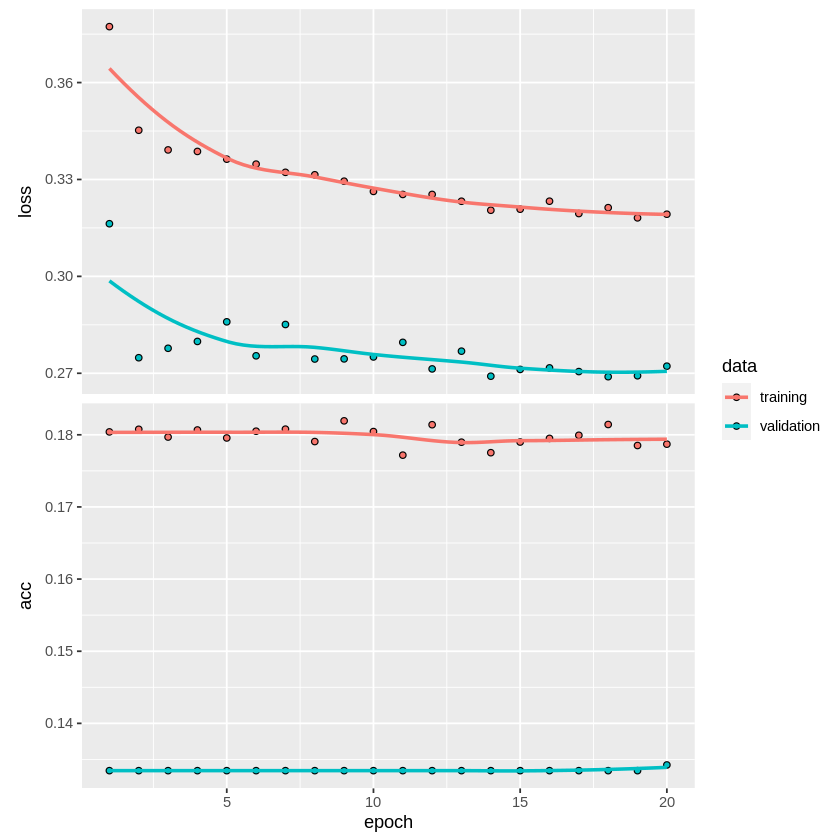

In [ ]:
plot(history)





not impressive!

### GRU RNN

    user   system  elapsed 
3361.801   77.903 3743.477 

loss       acc 
0.3063812 0.8536634

`geom_smooth()` using formula 'y ~ x'



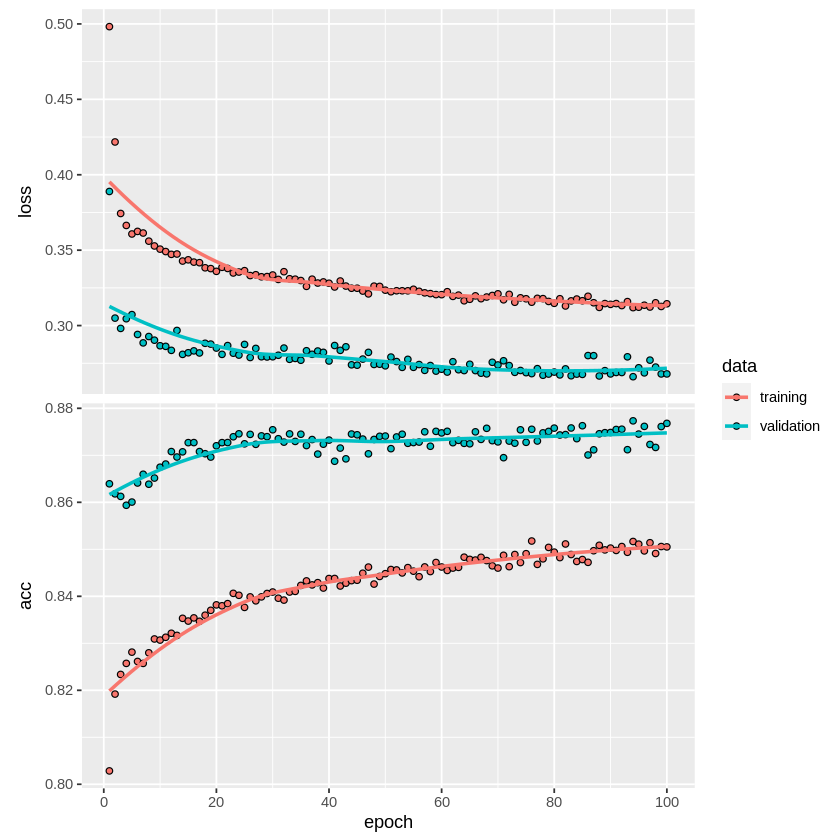

In [ ]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 8, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>% 
  layer_dense(units = 1, activation="sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "acc"
)

system.time(history <- model %>% fit(
  train_gen,
  steps_per_epoch = 200,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
))

model %>% evaluate(test_gen, steps=test_steps)

plot(history)



about 0.85 pretty impressive.  still seeing some improvement.  Should it go longer?

### 2 layer GRU RNN

    user   system  elapsed 
3530.373   80.119 4057.775 

loss       acc 
0.2888958 0.8616953

`geom_smooth()` using formula 'y ~ x'



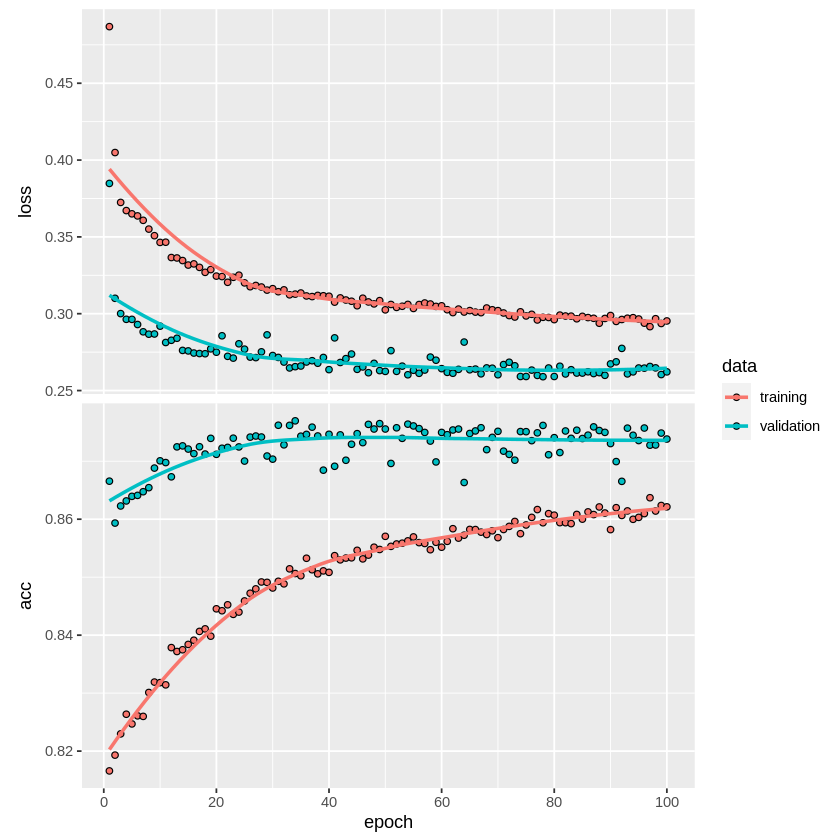

In [6]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 8, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE,
            return_sequences = TRUE) %>% 
  layer_gru(units = 8, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "acc"
)

system.time(history <- model %>% fit(
  train_gen,
  steps_per_epoch = 200,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
))

model %>% evaluate(test_gen, steps=test_steps)

plot(history)

That is working well.  looks like could train longer or have more layers/units. 

## More GRU

try a larger initial layer

    user   system  elapsed 
3543.117   79.022 3984.411 

loss       acc 
0.2474164 0.8923711

`geom_smooth()` using formula 'y ~ x'



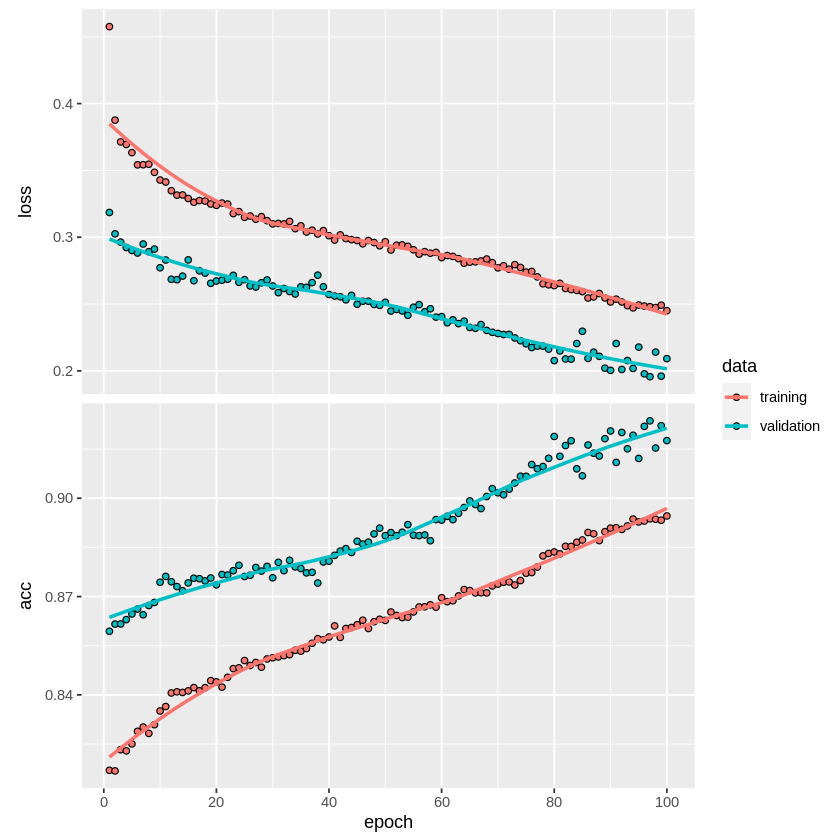

In [7]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 16, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE,
            return_sequences = TRUE) %>% 
  layer_gru(units = 8, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "acc"
)

system.time(history <- model %>% fit(
  train_gen,
  steps_per_epoch = 200,
  epochs = 100,
  validation_data = val_gen,
  validation_steps = val_steps
))

model %>% evaluate(test_gen, steps=test_steps)

plot(history)

Add more epochs

    user   system  elapsed 
7054.483  166.230 8184.927 

loss      acc 
0.242543 0.891683

`geom_smooth()` using formula 'y ~ x'



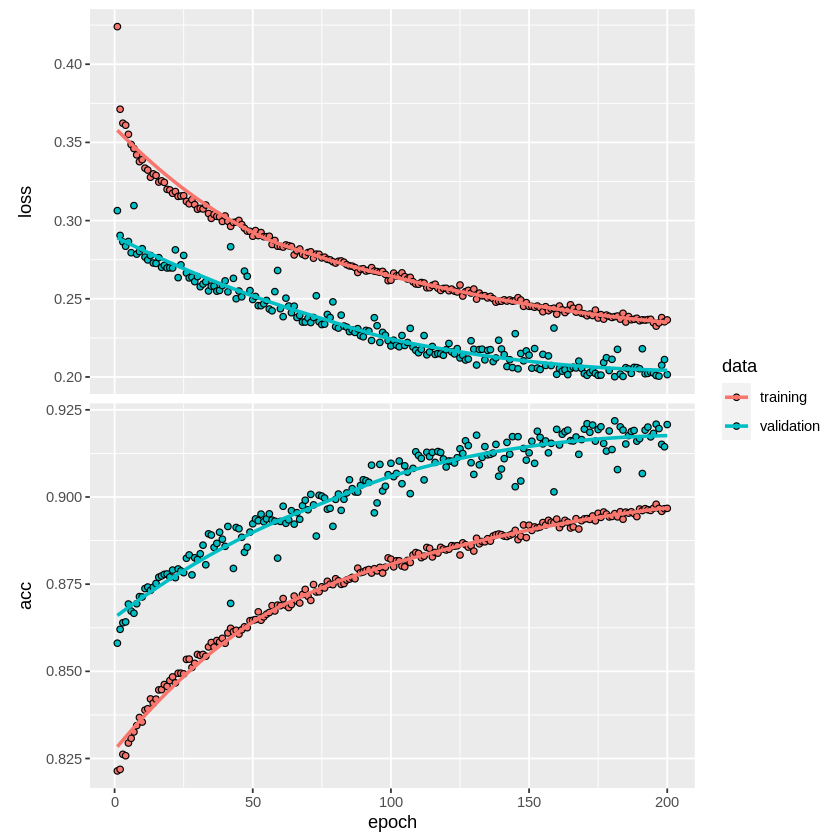

In [6]:
model <- keras_model_sequential() %>% 
  layer_gru(units = 16, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE,
            return_sequences = TRUE) %>% 
  layer_gru(units = 8, 
            input_shape = list(NULL, 2*(dim(chr1)[-1]-1)),
            recurrent_activation = "sigmoid",
            use_bias = TRUE,
            reset_after = TRUE) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = "acc"
)

system.time(history <- model %>% fit(
  train_gen,
  steps_per_epoch = 200,
  epochs = 200,
  validation_data = val_gen,
  validation_steps = val_steps
))

model %>% evaluate(test_gen, steps=test_steps)

plot(history)